In [1]:
### Tokenizer call
from transformers import AutoTokenizer
name = 'klue/bert-base'

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# https://huggingface.co/docs/transformers/model_doc/auto
tokenizer = AutoTokenizer.from_pretrained(name)
# 가능한 configuration
# https://huggingface.co/docs/transformers/v4.18.0/en/main_classes/configuration#transformers.PretrainedConfig

In [7]:
tokenizer

PreTrainedTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [8]:
# tokenizer의 model_max_len이 있고, 
# Parameters for sequence generation에 max_length가 있다.

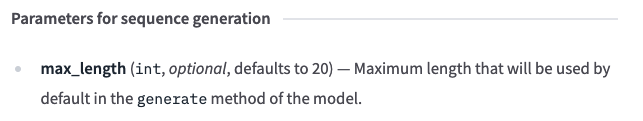

In [9]:
# AutoTokenizer
# Tokenizer 종류
# https://github.com/huggingface/transformers/blob/v4.18.0/src/transformers/models/auto/tokenization_auto.py#L351

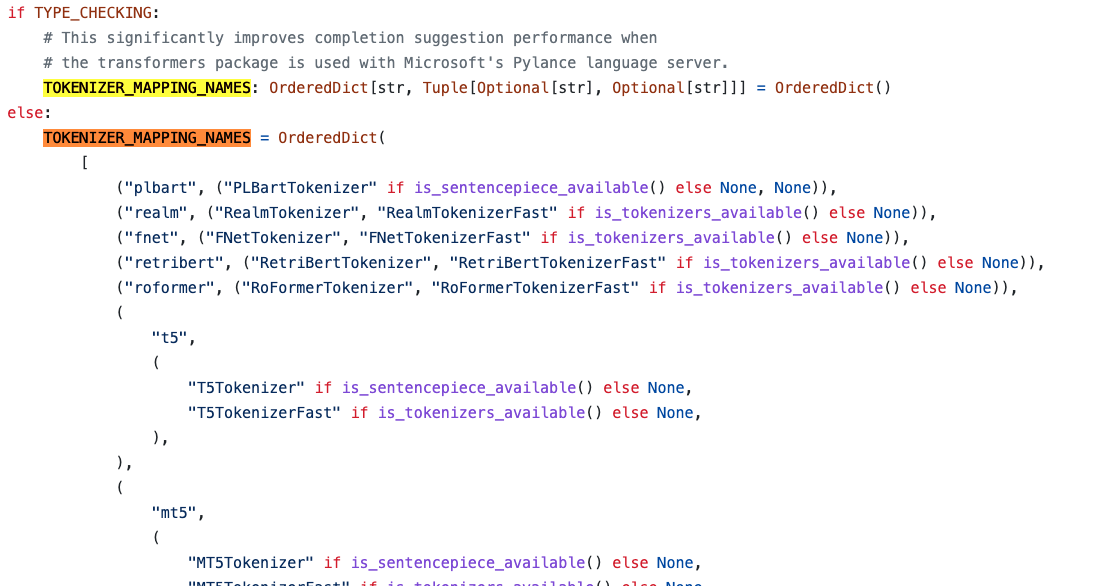

### Tokenizer의 탄생 과정
* SpecialTokensMixin, PushToHubMixin 를 상속받아서
* [PreTrainedTokenizerBase](https://github.com/huggingface/transformers/blob/31ec2cb2badfbdd4c1ac9c6c9b8a74e974984206/src/transformers/tokenization_utils_base.py#L1428)를 상속받아서
* [PreTrainedTokenizer](https://github.com/huggingface/transformers/blob/31ec2cb2badfbdd4c1ac9c6c9b8a74e974984206/src/transformers/tokenization_utils.py#L332) 를 상속받은
* 구체적인 모델의 Tokenizer

In [ ]:
### Tokenizer 가 call 되면 어떤 것이 수행되는걸까


### Tokenizer를 선언할 때의 kwargs와 __call__할때의 kwargs는 무엇이 있을까
* 왜 알려고 하는가? -> Tokenizer의 model_max_length, max_len 을 설정하면 알아서 맞춰진다고 착각했지모야

In [14]:
test_sentence= ['이번 대회는 어렵지만 차근차근 공부를 해봅니다']
tokenizer = AutoTokenizer.from_pretrained(name,
                                          max_len=5,
                                          use_fast=True)

In [15]:
tokenizer(test_sentence) #나는 max_len 해줬다고 생각했는데 왜 안짤리니?

{'input_ids': [[2, 3686, 3931, 2259, 4258, 3683, 16276, 4244, 2138, 1897, 29384, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [18]:
tokenizer(test_sentence,max_length=5) 
# 심지어 max_len 도 아니고, model_max_length도 아니고 max_length 는 뭔가
# 일단 truncation 되어버렸음..

{'input_ids': [[2, 3686, 3931, 2259, 3]], 'token_type_ids': [[0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [19]:
tokenizer(test_sentence,max_length=5, stride=2) # stride 만 넣는다고 능사가 아니여

{'input_ids': [[2, 3686, 3931, 2259, 3]], 'token_type_ids': [[0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1]]}

In [20]:
tokenizer(test_sentence,max_length=5, stride=2,return_overflowing_tokens=True )

{'input_ids': [[2, 3686, 3931, 2259, 3], [2, 3931, 2259, 4258, 3], [2, 2259, 4258, 3683, 3], [2, 4258, 3683, 16276, 3], [2, 3683, 16276, 4244, 3], [2, 16276, 4244, 2138, 3], [2, 4244, 2138, 1897, 3], [2, 2138, 1897, 29384, 3]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]], 'overflow_to_sample_mapping': [0, 0, 0, 0, 0, 0, 0, 0]}

### Tokenizer 가 __call__될 때 수행되는 것을 살펴보자
* [PreTrainedTokenizerBase](https://github.com/huggingface/transformers/blob/31ec2cb2badfbdd4c1ac9c6c9b8a74e974984206/src/transformers/tokenization_utils_base.py#L2372)에서 `__call__` 을 보면...
* `encode_plus`를 반환하고 encode_plus는 `_encode_plus` 를 반환하고
* _encode_plus 는 NotImplementedError다. 즉 상속받아서 고쳐써라는 것 같다.

### [PreTrainedToeknizer](https://github.com/huggingface/transformers/blob/v4.18.0/src/transformers/tokenization_utils.py#L332)를 통해 `_encode_plus`를 보면!!!
* tokenize가 수행되고, convert_tokens_to_ids가 수행된다
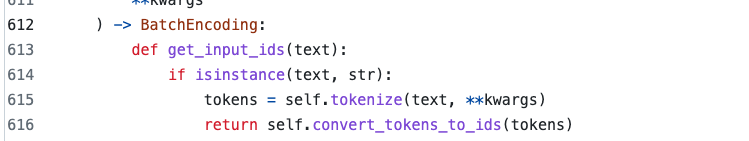
* 그리고 `prepare_for_model`이 수행되는데 이건 다시 [Base 클래스에서](https://github.com/huggingface/transformers/blob/31ec2cb2badfbdd4c1ac9c6c9b8a74e974984206/src/transformers/tokenization_utils_base.py#L2897) 수행된다.

### encode와 encode_plus 차이
* 학습에 필요한거 더 붙여준다[(참고)](https://stackoverflow.com/questions/61708486/whats-difference-between-tokenizer-encode-and-tokenizer-encode-plus-in-hugging)



In [22]:
# https://github.com/huggingface/transformers/blob/31ec2cb2badfbdd4c1ac9c6c9b8a74e974984206/src/transformers/tokenization_utils_base.py#L2191
tokenizer.encode(test_sentence[0],
                 max_length=5, 
                 stride=2,
                 return_overflowing_tokens=True )

[[2, 3686, 3931, 2259, 3],
 [2, 3931, 2259, 4258, 3],
 [2, 2259, 4258, 3683, 3],
 [2, 4258, 3683, 16276, 3],
 [2, 3683, 16276, 4244, 3],
 [2, 16276, 4244, 2138, 3],
 [2, 4244, 2138, 1897, 3],
 [2, 2138, 1897, 29384, 3]]

In [23]:
tokenizer.encode(test_sentence[0],
                 max_length=5, 
                 stride=2, )

[2, 3686, 3931, 2259, 3]

In [24]:
tokenizer.encode_plus(test_sentence[0],
                 max_length=5, 
                 stride=2,
                 return_overflowing_tokens=True )

{'input_ids': [[2, 3686, 3931, 2259, 3], [2, 3931, 2259, 4258, 3], [2, 2259, 4258, 3683, 3], [2, 4258, 3683, 16276, 3], [2, 3683, 16276, 4244, 3], [2, 16276, 4244, 2138, 3], [2, 4244, 2138, 1897, 3], [2, 2138, 1897, 29384, 3]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]], 'overflow_to_sample_mapping': [0, 0, 0, 0, 0, 0, 0, 0]}

### [prepare_for_model](https://github.com/huggingface/transformers/blob/31ec2cb2badfbdd4c1ac9c6c9b8a74e974984206/src/transformers/tokenization_utils_base.py#L2897)에서 하는 것 == 핵많다
* truncate
* overflowing token 관리
* padding
* 어 근데 어딘가로 이동되었다..[여기](https://github.com/huggingface/transformers/blob/6d80c92c77593dc674052b5a46431902e6adfe88/src/transformers/models/layoutlmv2/tokenization_layoutlmv2.py#L913)..? 통합체인가?
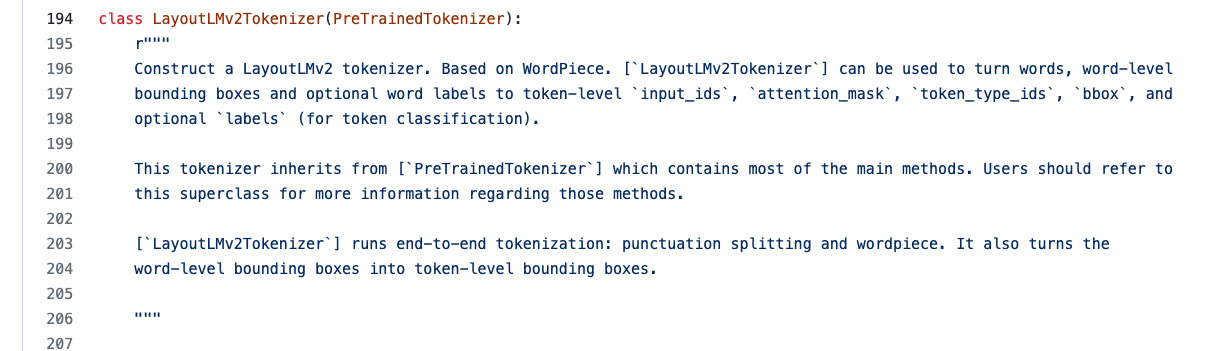


### model_max_length, max_len, max_length 뭔데
* [PreTrainedTokenizerBase line 1456](https://github.com/huggingface/transformers/blob/v4.18.0/src/transformers/tokenization_utils_base.py#L1428) 를 보면 Tokenizer의 input인 `model_max_length`, `max_len` 2가지를 아래처럼 처리한다
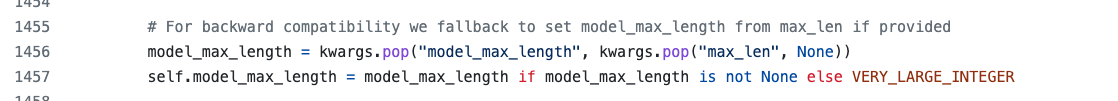

* [INIT_TOKENIZER_DOCSTRING](https://github.com/huggingface/transformers/blob/31ec2cb2badfbdd4c1ac9c6c9b8a74e974984206/src/transformers/tokenization_utils_base.py#L1384) 에서의 model_max_length 는 아래와 같은데,
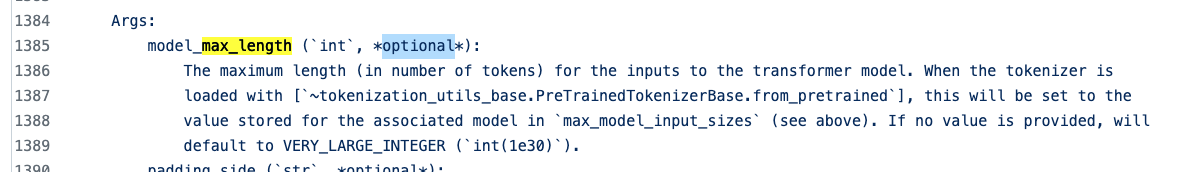


* 하지만 [ENCODE_WKARGS_DOCSTRING을 통해 실제 truncation에 관여](https://github.com/huggingface/transformers/blob/31ec2cb2badfbdd4c1ac9c6c9b8a74e974984206/src/transformers/tokenization_utils_base.py#L1281)하는건 `max_length`라 어떤 차이가 있는지 모르겠다

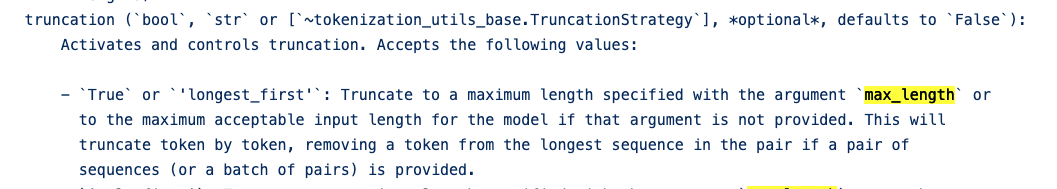
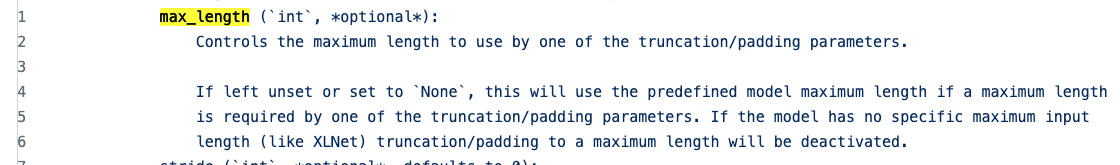

### model_max_length 의 쓰임은
* 실제로 쓰이는 경우를 보면 property 함수 호출 될 때 쓰이는데, 이 함수들이 어느 시점에 쓰이는질 아직 모르겠다.
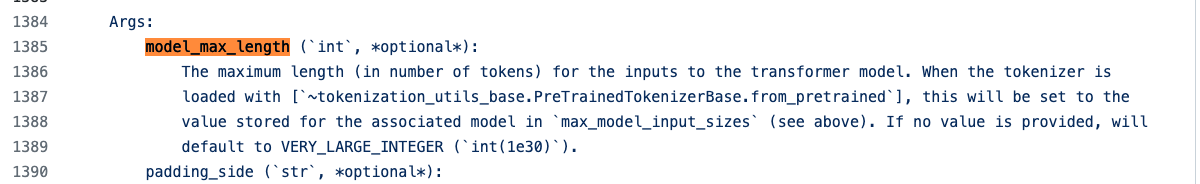
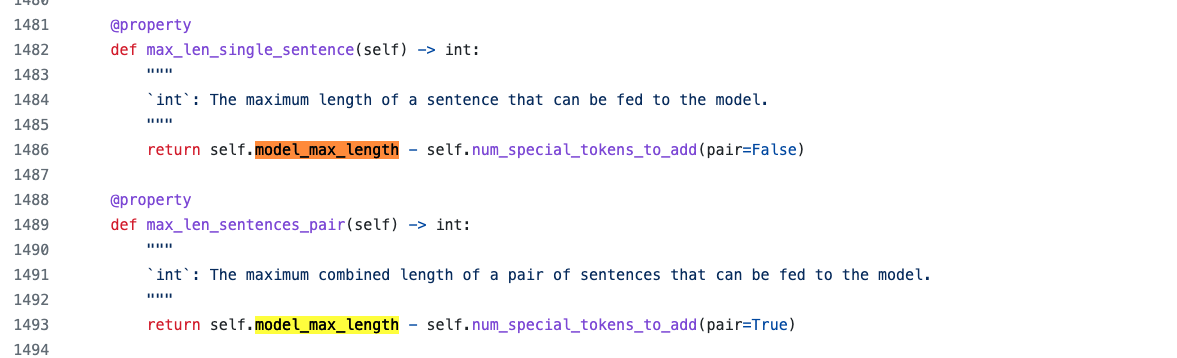

### max_length 쓰임은
* [truncate_sequences](https://github.com/huggingface/transformers/blob/31ec2cb2badfbdd4c1ac9c6c9b8a74e974984206/src/transformers/tokenization_utils_base.py#L2979)에 쓰이게된다
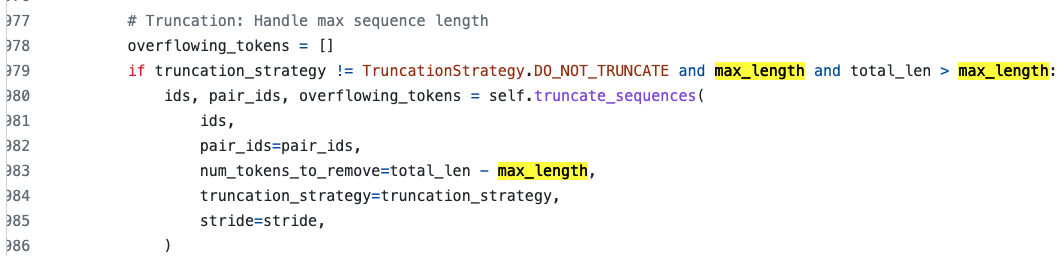
* [BertFast](https://github.com/huggingface/transformers/blob/6d80c92c77593dc674052b5a46431902e6adfe88/src/transformers/tokenization_utils_fast.py#L76) 버전을 쓰면 truncate pad 동시에 적용되어 있음

In [25]:
### encode_batch 를 알아야 offset 원리를 알 수 있는데
# https://github.com/huggingface/transformers/blob/6d80c92c77593dc674052b5a46431902e6adfe88/src/transformers/tokenization_utils_fast.py#L425

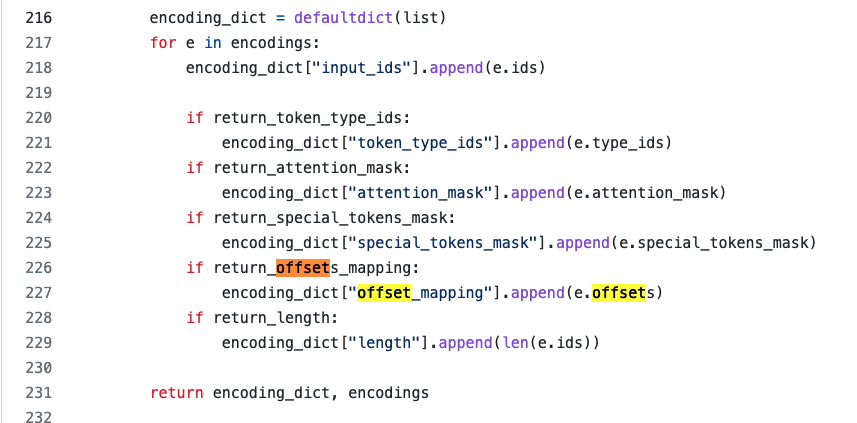
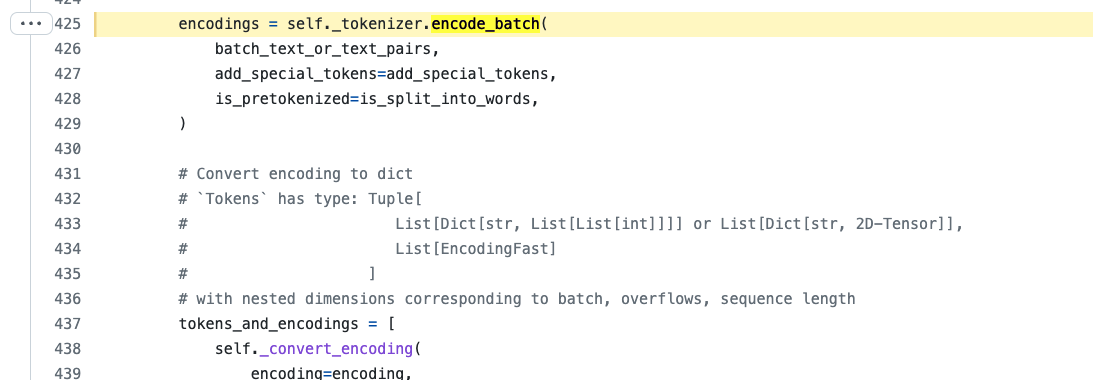